# Training

In [1]:
import pickle
import numpy as np
import os
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from keras.api.callbacks import EarlyStopping
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from keras.api.models import load_model


# Directories
DATA_DIR = '../../data'
AUDIOS_DIR = DATA_DIR + '/audios'
POS_AUDIOS_DIR = AUDIOS_DIR + '/positive'
NEG_AUDIOS_DIR = AUDIOS_DIR + '/negative'

MODELS_DIR = '../../models'
PLOTS_DIR = '../../plots'


## Mayor constants

In [2]:
FEATURE = 'chroma' # 'mfcc', 'chroma', 'lfcc'
MODEL = 'cnn' # 'cnn', 'lstm', 'ff'

### Load data

In [3]:
with open(f"{DATA_DIR}/{FEATURE}.pkl", "rb") as f:
    data = pickle.load(f)

# Positive data
positive_data = np.array(data["positive"])
positive_labels = np.ones(positive_data.shape[0])
pnames = data["pnames"]

# Negative data
negative_data = np.array(data["negative"])
negative_labels = np.zeros(negative_data.shape[0])
nnames = data["nnames"]

# Concatenate the data
X = np.concatenate((positive_data, negative_data), axis=0)
y = np.concatenate((positive_labels, negative_labels), axis=0)
names = np.concatenate((pnames, nnames), axis=0)

# Establecer la semilla aleatoria
seed = 1  # Elige cualquier número entero como semilla
rng = np.random.default_rng(seed)

# Shuffle the data using the random number generator
idx = rng.permutation(len(X))

X = X[idx]
y = y[idx]
names = names[idx]

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")


X shape: (10000, 12, 313)
y shape: (10000,)


### Preprocess pipeline

In [4]:
# Funciones auxiliares
def normalize(X):
    return (X - np.mean(X)) / np.std(X)

def sub_extra_column(X):
    return X[:, :, :-1]

def transpose(X):
    return X.transpose(0, 2, 1)

# Definición del pipeline
preprocessing_pipeline = Pipeline([
    ('normalize', FunctionTransformer(normalize, validate=False)),  # Normalización
    ('scale', MinMaxScaler(feature_range=(0, 1))),                  # Escalado
    ('sub_column', FunctionTransformer(sub_extra_column, validate=False)),  # Quitar columna
    ('transpose', FunctionTransformer(transpose, validate=False)),  # Transponer
])

# Aplicar el pipeline
def process_and_encode(X):
    # Reshape para MinMaxScaler (flatten y restaurar)
    X = preprocessing_pipeline.named_steps['normalize'].transform(X)
    X = preprocessing_pipeline.named_steps['scale'].fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)
    X = preprocessing_pipeline.named_steps['sub_column'].transform(X)
    X = preprocessing_pipeline.named_steps['transpose'].transform(X)
    
    # Predicción con el encoder
    encoder = load_model(f'{MODELS_DIR}/encoders/encoder_{FEATURE}.keras')
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    XC = encoder.predict(X)
    return XC

X = process_and_encode(X)
print(X.shape)
print(X)


c:\Users\angel\anaconda3\envs\TFG\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
(10000, 78, 12, 1)
[[[[0.62108636]
   [0.60769403]
   [0.569591  ]
   ...
   [0.32571682]
   [0.06752334]
   [0.52740574]]

  [[0.66648084]
   [0.6544966 ]
   [0.37292227]
   ...
   [0.54866236]
   [0.5082909 ]
   [0.70076126]]

  [[0.62001276]
   [0.60741144]
   [0.20081595]
   ...
   [0.6041537 ]
   [0.53382474]
   [0.6343902 ]]

  ...

  [[0.4526554 ]
   [0.38120735]
   [0.24898107]
   ...
   [0.05209123]
   [0.08798362]
   [0.4430959 ]]

  [[0.2525569 ]
   [0.3522383 ]
   [0.27879268]
   ...
   [0.03759006]
   [0.04269599]
   [0.18946986]]

  [[0.69752413]
   [0.68536526]
   [0.7014497 ]
   ...
   [0.6839522 ]
   [0.68924844]
   [0.75376827]]]


 [[[0.07677631]
   [0.04885003]
   [0.15562993]
   ...
   [0.55476314]
   [0.2286406 ]
   [0.13033888]]

  [[0.00930292]
   [0.00507555]
   [0.02399982]
   ...
   [0.3772579 ]
   [0.07057121]
   [0.06842919]]

  [[0.00860749]
   [0.00558898]
   [0.05089096]
   ...
   [0.49078912]
   [0.12732434]
   [

### Training

In [5]:
percent = 1
trn_size = 0.8
tst_size = (1-trn_size)

print(X.shape)
print(y.shape)

X_train, X_tst, y_train, y_tst, idxtrn, idxtst = train_test_split(X, y,
                                                np.arange(len(X)),
                                                train_size=trn_size*percent,
                                                test_size=tst_size*percent,
                                                stratify=y,
                                                random_state=seed)

# Mantain the names of the audios
names = np.array(names)
namestrn = names[idxtrn]
namestst = names[idxtst]

print(X_train.shape)
print(y_train.shape)
print(X_tst.shape)
print(y_tst.shape)


(10000, 78, 12, 1)
(10000,)
(8000, 78, 12, 1)
(8000,)
(2000, 78, 12, 1)
(2000,)


In [6]:
from keras.api.layers import Input, Conv2D, MaxPooling2D
from keras.api.layers import Flatten, Dense, Dropout
from keras.api.models import Sequential

def CNN(optimizer='adam', units=24, activation='relu', dropout_rate=0.2):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2], X.shape[3])),
        Conv2D(4, (7, 7), activation=activation, padding='same'),
        MaxPooling2D((2, 1)),
        Dropout(dropout_rate),

        Conv2D(8, (5, 5), activation=activation, padding='same'),
        MaxPooling2D((3, 1)),
        Dropout(dropout_rate),

        Conv2D(16, (5, 5), activation=activation, padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        Conv2D(32, (3, 3), activation=activation, padding='same'),
        MaxPooling2D((2, 2)),
        Dropout(dropout_rate),

        Flatten(),

        Dense(units, activation=activation),
        Dropout(dropout_rate),

        Dense(units//2, activation=activation),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid'),
    ], name="CNN")

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

CNN().summary()

Model: "CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 12, 4)      │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 12, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 39, 12, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 39, 12, 8)      │           808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 12, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 12, 16)     │         3,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 288)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         6,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 12)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            13 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,113 (62.94 KB)

 Trainable params: 16,113 (62.94 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
from keras.api.models import Sequential
from keras.api.layers import LSTM, Dense, Input, Dropout
from keras.api.regularizers import l2
import numpy as np

def LSTM_MODEL(optimizer='adam', units=16, activation='relu', dropout_rate=0.2):

    model = Sequential(name='LSTM')

    model.add(Input(shape=(X.shape[1], X.shape[2])))

    # Segunda capa LSTM
    model.add(LSTM(units, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.03)))
    model.add(Dropout(dropout_rate))

    model.add(Dense(units//2, activation=activation))
    model.add(Dropout(dropout_rate))

    # Capa de salida para clasificación binaria
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

LSTM_MODEL().summary()

Model: "LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 16)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,001 (7.82 KB)

 Trainable params: 2,001 (7.82 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from keras.api.models import Sequential
from keras.api.layers import Flatten, Dense, Input, Dropout
import numpy as np

def FF(optimizer='adam', units=128, activation='relu', dropout_rate=0.2):
    model = Sequential([
        Input(shape=(X.shape[1], X.shape[2], 1)),

        Flatten(),

        Dense(units, activation=activation),
        Dropout(dropout_rate),

        Dense(units//2, activation=activation),
        Dropout(dropout_rate),

        Dense(units//4, activation=activation),
        Dropout(dropout_rate),

        Dense(1, activation='sigmoid'),
    ], name="FF")

    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

FF().summary()

Model: "FF"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 936)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       119,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 130,305 (509.00 KB)

 Trainable params: 130,305 (509.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from itertools import product
import gc
import tensorflow as tf

TRAINING = {
    'cnn': CNN,
    'lstm': LSTM_MODEL,
    'ff': FF,
}

def save_fig(MODEL, FEATURE, timestamp):
    ruta_carpeta = f"{PLOTS_DIR}/{MODEL}_{FEATURE}"
    ruta_archivo = f"{ruta_carpeta}/{timestamp}.png"

    # Crea la carpeta si no existe
    os.makedirs(ruta_carpeta, exist_ok=True)  # exist_ok evita error si ya existe
    plt.savefig(ruta_archivo)

# Almacena las métricas para cada combinación de parámetros
results = []

# Lista de todas las combinaciones de parámetros
param_combinations = list(product(
    [64, 128, 256],     # units
    [0.1, 0.2, 0.3], # dropout_rate
    ['relu'], # activation
))


In [44]:
percent = 0.5
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=seed)
for params in param_combinations:
    
    units, dropout_rate, activation = params
    print(f"\nProbando combinación de parámetros: {params}")

    accuracies = []
    losses = []
    histories = []
    times = []
    fold = 1
    for train_index, val_index in kf.split(X_train):
        print(f"Fold {fold}: ")

        xtrn, xval = X_train[train_index], X_train[val_index]
        ytrn, yval = y_train[train_index], y_train[val_index]

        xtrn = xtrn[:int(len(xtrn)*percent)]
        ytrn = ytrn[:int(len(ytrn)*percent)]

        # Crear el EarlyStopping callback
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01, restore_best_weights=True)

        # Crear el modelo con los parámetros actuales
        model = TRAINING[MODEL](optimizer='adam',
                    units=units,
                    activation=activation,
                    dropout_rate=dropout_rate)

        # Entrenar el modelo
        start_time = time.time()
        history = model.fit(xtrn, ytrn,
                    validation_data=(xval, yval),
                    epochs=200,
                    batch_size=64,
                    verbose=1,
                    callbacks=[early_stopping])
        end_time = time.time()

        # Obtener la mejor epoca
        idx = np.argmin(history.history['val_loss'])
        losses.append(history.history['val_loss'][idx])
        accuracies.append(history.history['val_accuracy'][idx])
        times.append(end_time - start_time)
        print(f"Fold {fold} - Pérdida de validación: {losses[-1]:.5f}")
        print(f"Fold {fold} - Accuracy de validación: {accuracies[-1]:.5f}")

        histories.append(history)

        del model
        fold += 1
        
        # Liberar recursos de memoria
        tf.keras.backend.clear_session()
        gc.collect()

    # Almacenar métricas de la combinación actual
    mean_time = np.mean(times)
    time_str = time.strftime("%H:%M:%S", time.gmtime(mean_time))
    results.append({
        'params': params,
        'percent': percent,
        'time': time_str,
        'mean_accuracy': np.mean(accuracies),
        'mean_loss': np.mean(losses)
    })

    # Imprimir los resultados finales
    for result in results:
        print(f"Parámetros: {result['params']}, \
                Porcentaje: {result['percent']}, \
                Tiempo: {result['time']}, \
                Mean Accuracy: {result['mean_accuracy']:.4f}, \
                Mean Loss: {result['mean_loss']:.4f}")

    # Store model with timestamp with year, month, day, hour, minute and second
    timestamp = time.strftime("%Y%m%d%H%M%S")

    # Save params in a .txt file for every model
    with open(f"../../params/{MODEL}_{FEATURE}_params.txt", "a") as f:
        f.write(f"ID: {timestamp}\n")
        f.write(f"Porcentaje: {result['percent']}\n")
        f.write(f"Parámetros: {result['params']}\n")
        f.write(f"Tiempo medio: {result['time']}\n")
        f.write(f"Accuracy medio: {result['mean_accuracy']:.4f}\n")
        f.write(f"Loss medio: {result['mean_loss']:.4f}\n\n")

    # Plot acc and loss for each fold, training and validation
    # Using a k, 2 subplot grid
    plt.figure(figsize=(15, 6))

    for i in range(k):
        plt.subplot(2, k, i+1)
        plt.plot(histories[i].history['loss'], label=f'Fold {i+1} Training')
        plt.plot(histories[i].history['val_loss'], label=f'Fold {i+1} Validation')
        plt.title('Loss')
        plt.ylim(0, 0.8)
        plt.grid()
        plt.legend()

        plt.subplot(2, k, i+1 + k)
        plt.plot(histories[i].history['accuracy'], label=f'Fold {i+1} Training')
        plt.plot(histories[i].history['val_accuracy'], label=f'Fold {i+1} Validation')
        plt.title('Accuracy')
        plt.ylim(0.5, 1)
        plt.grid()
        plt.legend()

    plt.tight_layout()
    save_fig(MODEL, FEATURE, timestamp)
    plt.close()
    plt.show()



Probando combinación de parámetros: (64, 0.1, 'relu')
Fold 1: 
Epoch 1/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.4957 - loss: 0.7289 - val_accuracy: 0.4837 - val_loss: 0.6938
Epoch 2/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5107 - loss: 0.6942 - val_accuracy: 0.4869 - val_loss: 0.6928
Epoch 3/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5101 - loss: 0.6933 - val_accuracy: 0.5131 - val_loss: 0.6923
Epoch 4/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4911 - loss: 0.6948 - val_accuracy: 0.4944 - val_loss: 0.6918
Epoch 5/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5327 - loss: 0.6904 - val_accuracy: 0.5375 - val_loss: 0.6890
Epoch 6/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5218 - loss: 0.6918 - val_accuracy: 0.5619 - val_loss: 0.6871
Epoch 7/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5194 - loss: 0.6920 - val_accuracy: 0.5694 - val_loss: 0.6892
Epoch 8/200
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/

In [38]:
# Test with best params
units = 64
dropout_rate = 0.1
activation = 'relu'

# Crear el EarlyStopping callback
early_stopping = EarlyStopping(monitor='loss', patience=25, min_delta=0.005, restore_best_weights=True)

# Crear el modelo con los parámetros actuales
model = TRAINING[MODEL](optimizer='adam',
            units=units,
            activation=activation,
            dropout_rate=dropout_rate)

# Entrenar el modelo
history = model.fit(X_train, y_train,
            epochs=20,
            batch_size=64)

# Evaluar el modelo
loss, acc = model.evaluate(X_tst, y_tst)
print(f"Test Accuracy: {acc:.4f}, Test Loss: {loss:.4f}")


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 51ms/step - accuracy: 0.6357 - loss: 0.5873
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8815 - loss: 0.2892
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8977 - loss: 0.2699
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9091 - loss: 0.2350
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9220 - loss: 0.1964
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9341 - loss: 0.1636
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9445 - loss: 0.1432
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9463 - loss: 0.1354
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9522 - loss: 0.1280
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9536 - loss: 0.1243
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.9500 - loss: 0.1224
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 

In [39]:
# Save the model
model.save(f"{MODELS_DIR}/{MODEL}_{FEATURE}_{loss:.4f}.keras")


# Evaluation

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

    Negative       0.92      0.98      0.95      1000
    Positive       0.98      0.92      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000

[[985  15]
 [ 83 917]]
AUC: 0.9510


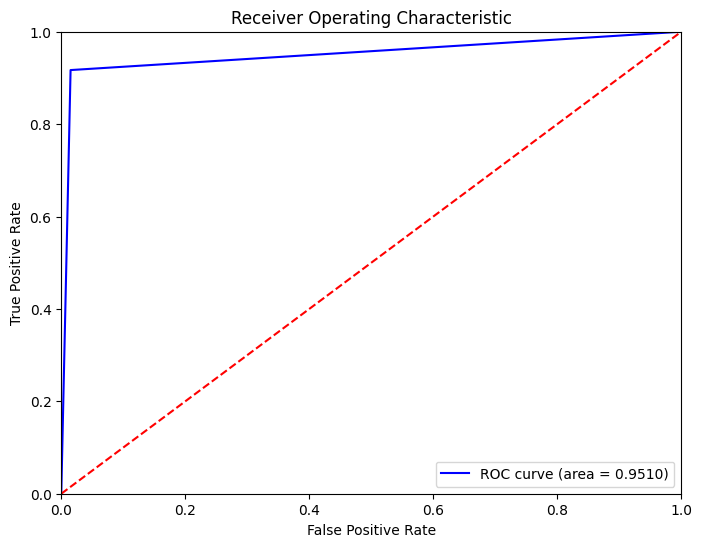

Normalized confusion matrix


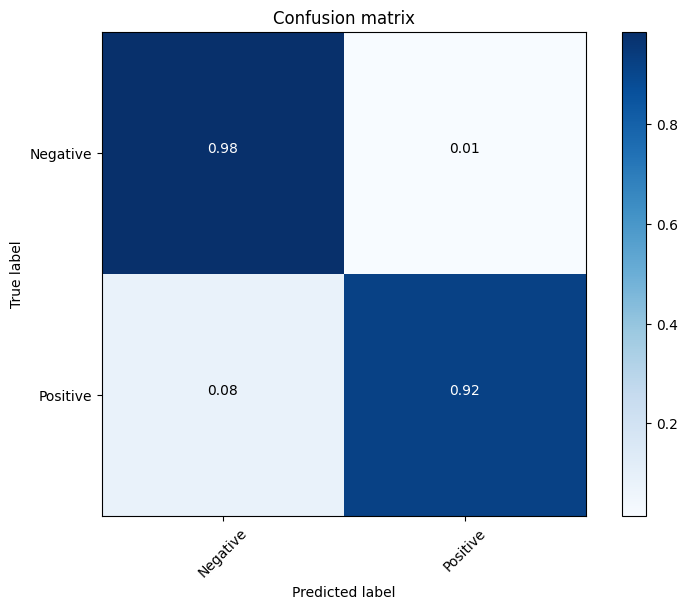

In [6]:
# Getting metrics such as accuracy, precision, recall, f1-score, confusion matrix, ROC and AUC
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import itertools

model = load_model(f"{MODELS_DIR}/{MODEL}_chroma_0.1107.keras")

# Predict the test set
y_pred = model.predict(X_tst)
y_pred = (y_pred > 0.5).astype(int)
y_pred = y_pred.flatten()

# Classification report
print(classification_report(y_tst, y_pred, target_names=['Negative', 'Positive']))
# Confusion matrix
cm = confusion_matrix(y_tst, y_pred)
print(cm)

# Plot confusion matrix
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Curva ROC y AUC
fpr, tpr, thresholds = roc_curve(y_tst, y_pred)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(cm, classes=['Negative', 'Positive'], normalize=True,
                      title='Confusion matrix')
plt.show()


In [24]:
# Reproducir audio con mayor tasa de error
import librosa.display
import IPython.display as ipd

# Obtener los índices de los audios con mayor tasa de error de los audios
# de prueba negativos
type = 0
best = 1
idxtst_type = np.where(y_tst == type)[0]

if type == 1:
    amount = 83
else:
    amount = 15

amount = 1000

model = load_model(f"{MODELS_DIR}/{MODEL}_{FEATURE}_0.1107.keras")

y_pred = model.predict(X_tst[idxtst_type])
y_pred = y_pred.flatten()

diff = np.abs(y_pred - y_tst[y_tst==type])

idx = np.argsort(diff)
if best == 0:
    idx = idx[::-1]

# Show names of the audios with higher error rate
names = []
predictions = []
for i in range(amount):
    names.append(namestst[idxtst_type][idx[i]])
    print(f"Audio: {namestst[idxtst_type][idx[i]]}, Predicted: {y_pred[idx[i]]}, True: {y_tst[y_tst==type][idx[i]]}")
    predictions.append(y_pred[idx[i]])


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Audio: 0-Fireworks-1ec6_7rR7Yo.wav, Predicted: 9.62496196734719e-05, True: 0.0
Audio: 0-Fireworks-hCX2DpwEBQY.wav, Predicted: 0.00012141099432483315, True: 0.0
Audio: 0-Chirp,_tweet-5tyZiD0-8z4.wav, Predicted: 0.00013544972171075642, True: 0.0
Audio: 0-Fireworks-1Gbs_uCx49M.wav, Predicted: 0.00016676104860380292, True: 0.0
Audio: 0-Clapping-7FHHtRuAz0s.wav, Predicted: 0.00017711411055643111, True: 0.0
Audio: 0-Clapping-w1QTsJn1z-g.wav, Predicted: 0.00020120339468121529, True: 0.0
Audio: 0-Train-DegfC2mWReU.wav, Predicted: 0.0002130585053237155, True: 0.0
Audio: 0-Male_speech,_man_speaking-kiAMVnSBGw0.wav, Predicted: 0.0002209751692134887, True: 0.0
Audio: 0-Bark-EakI8v4Ztt4.wav, Predicted: 0.00022391451057046652, True: 0.0
Audio: 0-Male_speech,_man_speaking-X62-7mo72jA.wav, Predicted: 0.00022879640164319426, True: 0.0
Audio: 0-Fireworks-LmlCcoUOaOs.wav, Predicted: 0.00024217188183683902, True: 0.0
Audio: 0-Rain-nfhsxetUM5Q.wav, Predicted: 0.00025

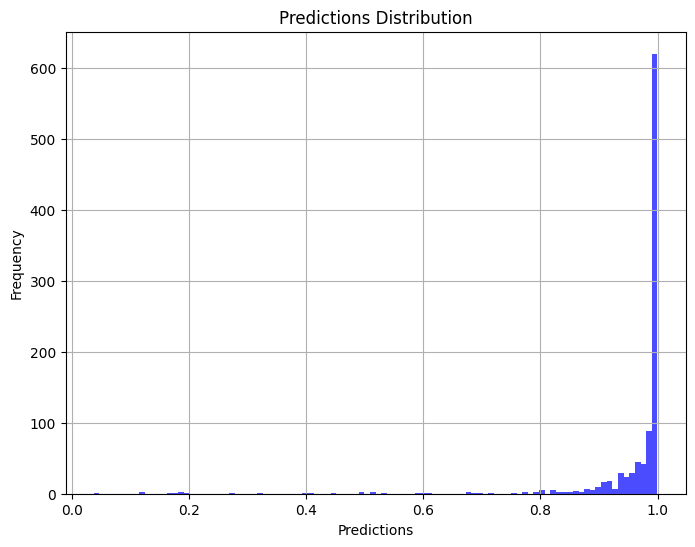

In [ ]:
# Plot y_pred distribution in bar plot in log10 scale

# Invert the predictions to show the negative ones
predictions = [1 - p for p in predictions]

plt.figure(figsize=(8, 6))
plt.hist(predictions, bins=10, color='blue', alpha=0.7)
plt.title('Predictions Distribution')
plt.xlabel('Predictions')
plt.ylabel('Frequency')
plt.grid()
plt.show()


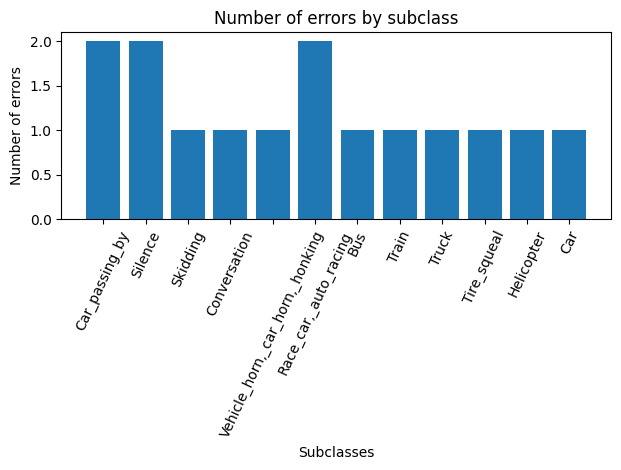

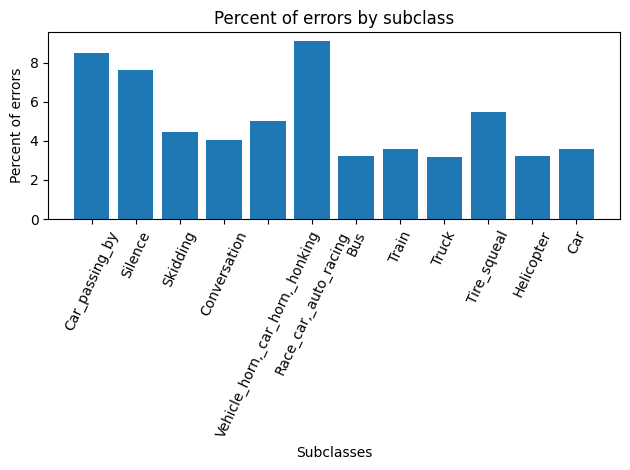

In [161]:
# Plotear de cada subclase cuantos fallos ha habido
subclases = {}
for name in names:
    # Extraer la subclase del nombre del audio
    subclase = name.split('-')[1]
    if subclase not in subclases:
        subclases[subclase] = 0
    subclases[subclase] += 1


# Sort subclasses alphabetically
if type == 0:
    percents = {'Air_horn,_truck_horn': 0.0232, 'Bark': 0.0246, 'Bicycle_bell': 0.0086, 'Bus': 0.031199999999999995, 'Car': 0.028000000000000004, 'Car_passing_by': 0.0236, 'Cheering': 0.0184, 'Child_speech,_kid_speaking': 0.02, 'Children_playing': 0.026000000000000002, 'Chirp,_tweet': 0.0268, 'Church_bell': 0.015599999999999998, 'Clapping': 0.0198, 'Conversation': 0.0246, 'Crowd': 0.021399999999999995, 'Dog': 0.0218, 'Drill': 0.030600000000000002, 'Female_speech,_woman_speaking': 0.0198, 'Fireworks': 0.0284, 'Helicopter': 0.031199999999999995, 'Jackhammer': 0.0318, 'Male_speech,_man_speaking': 0.0258, 'Motor_vehicle_(road)': 0.0268, 'Motorcycle': 0.0294, 'Music': 0.0208, 'Race_car,_auto_racing': 0.022, 'Rain': 0.0304, 'Sawing': 0.0314, 'Silence': 0.0262, 'Skidding': 0.022399999999999996, 'Thunder': 0.032, 'Thunderstorm': 0.0324, 'Tire_squeal': 0.0182, 'Traffic_noise,_roadway_noise': 0.0296, 'Train': 0.028000000000000004, 'Truck': 0.0316, 'Vehicle': 0.0294, 'Vehicle_horn,_car_horn,_honking': 0.02, 'Walk,_footsteps': 0.0316, 'Whistle': 0.0048, 'Wind': 0.0318}
    rot = 65
else:
    percents = {'Ambulance_(siren)': 0.0572, 'Emergency_vehicle': 0.6398, 'Fire_engine,_fire_truck_(siren)': 0.1352, 'Police_car_(siren)': 0.1678}
    rot = 20

# Bar plot
plt.bar(subclases.keys(), subclases.values())
plt.xlabel('Subclasses')
plt.ylabel('Number of errors')

plt.title('Number of errors by subclass')
plt.xticks(rotation=rot)
plt.tight_layout()
plt.show()

for i, subclase in enumerate(subclases.keys()):
    subclases[subclase] = subclases[subclase] / (1000 * percents[subclase]) * 100

# Bar plot
plt.bar(subclases.keys(), subclases.values())
plt.xlabel('Subclasses')
plt.ylabel('Percent of errors')

plt.title('Percent of errors by subclass')
plt.xticks(rotation=rot)
plt.tight_layout()
plt.show()



Reproduciendo audio: 0-Car_passing_by--AD-QFdGGzk.wav


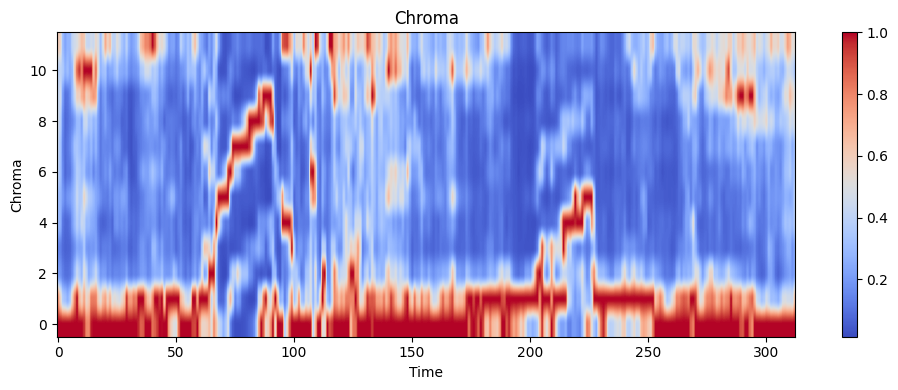

Audio: 0-Car_passing_by--AD-QFdGGzk.wav


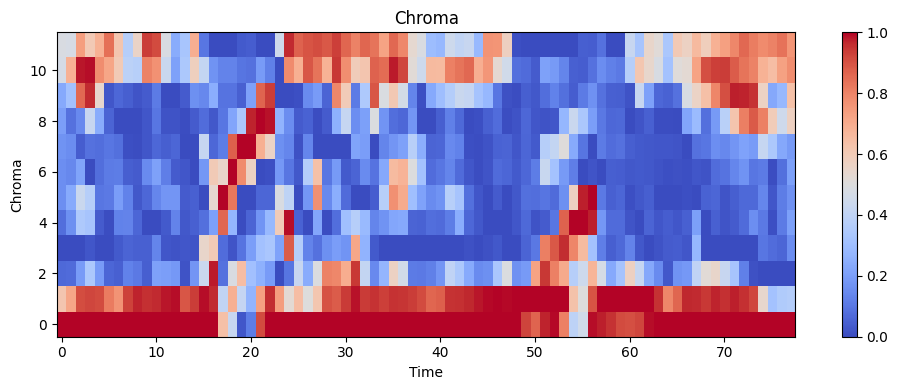

In [162]:
# Reproducir los audios con mayor tasa de error
chromas = []
if type == 1:
     dir = POS_AUDIOS_DIR
else:
    dir = NEG_AUDIOS_DIR
for i in range(1):
        audio_name = namestst[idxtst_type][idx[i]]
        audio_path = os.path.join(dir, audio_name)
        print(f"\nReproduciendo audio: {audio_name}")
        try:
            y, sr = librosa.load(audio_path, sr=16000)
            ipd.display(ipd.Audio(y, rate=sr))
        except FileNotFoundError:
            print(f"¡Error! No se encontró el archivo de audio en la ruta: {audio_path}")
        except Exception as e:
            print(f"Ocurrió un error al cargar el audio: {e}")

        # Cargar el chroma del audio
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Original version of the audio
# Plot chroma
plt.figure(figsize=(10, 4))
plt.title('Chroma')
plt.imshow(chroma, aspect='auto', origin='lower', cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Chroma')
plt.colorbar()
plt.tight_layout()
plt.show()

# Process version of the audio
tst = X_tst[idxtst_type][idx[0]]
tst = tst.reshape(tst.shape[0], tst.shape[1]*tst.shape[2])
tst = tst.transpose(1, 0)
# Map to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
tst = scaler.fit_transform(tst)
tst = 1 - tst
audio_name = namestst[idxtst_type][idx[0]]
print(f"Audio: {audio_name}")

# Plot chroma
plt.figure(figsize=(10, 4))
plt.title('Chroma')
plt.imshow(tst, aspect='auto', origin='lower', cmap='coolwarm')
plt.xlabel('Time')
plt.ylabel('Chroma')
plt.colorbar()
plt.tight_layout()
plt.show()
    